In [1]:
import pandas as pd
import json

# Expression data (genes x samples)
expr = pd.read_csv("data/SRP075806/SRP075806.tsv", sep="\t", index_col=0)

# Sample metadata
meta = pd.read_csv("data/SRP075806/metadata_SRP075806.tsv", sep="\t")

# Aggregated metadata (optional)
with open("data/aggregated_metadata.json") as f:
    agg_meta = json.load(f)

print(expr.shape)  # genes x samples
print(meta.head())


(43363, 116)
  refinebio_accession_code experiment_accession  refinebio_age  \
0               SRR3593218            SRP075806           60.0   
1               SRR3593219            SRP075806           60.0   
2               SRR3593220            SRP075806           60.0   
3               SRR3593221            SRP075806           60.0   
4               SRR3593222            SRP075806           60.0   

   refinebio_cell_line  refinebio_compound  refinebio_developmental_stage  \
0                  NaN                 NaN                            NaN   
1                  NaN                 NaN                            NaN   
2                  NaN                 NaN                            NaN   
3                  NaN                 NaN                            NaN   
4                  NaN                 NaN                            NaN   

  refinebio_disease  refinebio_disease_stage  refinebio_genetic_information  \
0               t2d                      NaN    

In [2]:
# Look at first few genes
print(expr.head())

# Match sample IDs in metadata
print(expr.columns[:5])
#print(meta['sample_accession'].head())


                 SRR3593218  SRR3593219  SRR3593220  SRR3593221  SRR3593222  \
Gene                                                                          
ENSG00000000003    5.117255    4.847048    4.908736    4.833782    4.673813   
ENSG00000000005    0.559150    0.444701    0.776822    0.799970    0.050217   
ENSG00000000419    5.528416    5.537584    6.194859    5.700547    5.640739   
ENSG00000000457    2.782441    2.812636    2.785896    2.783374    2.840038   
ENSG00000000460    2.303469    2.408211    2.196776    2.153675    2.252244   

                 SRR3593223  SRR3593224  SRR3593225  SRR3593226  SRR3593227  \
Gene                                                                          
ENSG00000000003    5.106616    4.900454    4.768684    4.991494    4.628079   
ENSG00000000005    0.551383    0.919837    1.038256    0.942459    0.878956   
ENSG00000000419    5.322609    5.546847    5.419967    5.517725    5.272013   
ENSG00000000457    2.894735    2.777675    2.813574

In [3]:
# Keep genes with counts > 1 in at least, say, 5 samples
filtered = expr[expr.gt(1).sum(axis=1) >= 5]
print(filtered.shape)


(24886, 116)


In [4]:
print(expr.iloc[:,0].describe())

count    43363.000000
mean         2.498305
std          7.314745
min          0.072327
25%          0.072327
50%          0.709433
75%          2.309189
max        197.476136
Name: SRR3593218, dtype: float64


In [5]:
# Log-transform if not already
import numpy as np
log_expr = np.log2(filtered + 1)

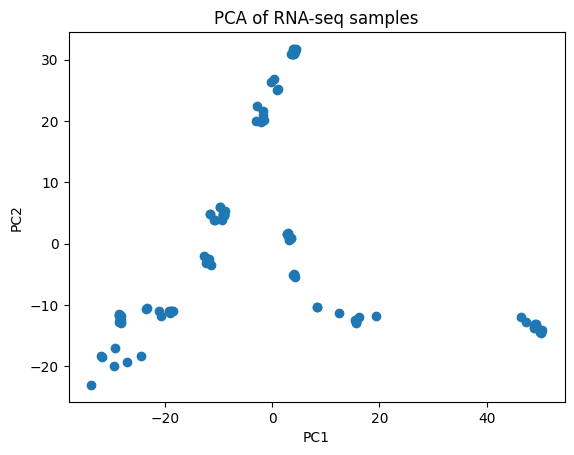

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pcs = pca.fit_transform(log_expr.T)  # transpose: samples x genes

plt.scatter(pcs[:,0], pcs[:,1])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of RNA-seq samples")
plt.show()


In [7]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Example: compare condition A vs B
# First make sure your metadata has a column for condition
print(meta.columns)

# Subset
samples = meta[meta['condition'].isin(['A', 'B'])]
sub_expr = log_expr[samples['sample_accession']]

# Fit linear model gene by gene
results = {}
for gene in sub_expr.index:
    df = samples.copy()
    df['expr'] = sub_expr.loc[gene].values
    model = smf.ols("expr ~ condition", data=df).fit()
    results[gene] = model.pvalues['condition[T.B]']

de_results = pd.Series(results, name="pvalue")


Index(['refinebio_accession_code', 'experiment_accession', 'refinebio_age',
       'refinebio_cell_line', 'refinebio_compound',
       'refinebio_developmental_stage', 'refinebio_disease',
       'refinebio_disease_stage', 'refinebio_genetic_information',
       'refinebio_organism', 'refinebio_platform', 'refinebio_processed',
       'refinebio_processor_id', 'refinebio_processor_name',
       'refinebio_processor_version', 'refinebio_race', 'refinebio_sex',
       'refinebio_source_archive_url', 'refinebio_source_database',
       'refinebio_specimen_part', 'refinebio_subject', 'refinebio_time',
       'refinebio_title', 'refinebio_treatment', 'MetaSRA_age'],
      dtype='object')


KeyError: 'condition'